In [1]:
import os
import random
import time
import copy
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from time import sleep
from xml.dom import minidom
from collections import deque

import torch
import cv2
import timm
from sklearn import preprocessing, metrics
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
import torch.nn.functional as F
from catalyst.data.sampler import BalanceClassSampler, MiniEpochSampler
from ranger import Ranger
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import albumentations as A
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, CoarseDropout,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2

import logging
logging.getLogger().setLevel(logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# seed everything
SEED = 55555

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [54]:
# hyperparameters
DATA_PATH = r"./train/"

IMAGE_SIZE = 300
BATCH_SIZE = 12
GRADIENT_ACCUMULATION_STEPS = 10
LEARNING_RATE = 0.0005
EPOCHS = 50

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    logging.info(f"Running on {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
    logging.info("Running on a CPU")

INFO:root:Running on GeForce GTX 1060 6GB


In [5]:
def build_dataset(quality_threshold=2, data_path=DATA_PATH, rewrite=False):
    if not rewrite:
        try:
            dataset = pd.read_csv("dataset.csv")
        except:
            pass
    else:
        image_paths = []
        labels = []
        image_qualities = []

        for xmldoc in tqdm_notebook(os.listdir(data_path)):
            if xmldoc.__contains__(".xml"):
                with open(data_path + xmldoc, "r", encoding="UTF-8") as f:
                    doc = f.read()
                doc = minidom.parseString(doc)

                label = doc.getElementsByTagName('ClassId')
                label = int(label[0].firstChild.nodeValue)

                image_path = doc.getElementsByTagName('FileName')
                image_path = image_path[0].firstChild.nodeValue            

                image_quality = doc.getElementsByTagName('Vote')
                image_quality = int(image_quality[0].firstChild.nodeValue)
                
                if image_quality > quality_threshold:
                    image_paths.append(data_path + image_path)
                    labels.append(label)
                    image_qualities.append(image_quality)

                dataset = pd.DataFrame({"image_path" : image_paths,
                                        "label" : labels,
                                        "image_quality" : image_quality})

    return dataset

dataset = build_dataset(rewrite=False)
dataset.to_csv("dataset.csv") 

In [6]:
le = preprocessing.LabelEncoder()
dataset["label"] = le.fit_transform(dataset["label"].values)

In [7]:
len(dataset["label"].value_counts())

500

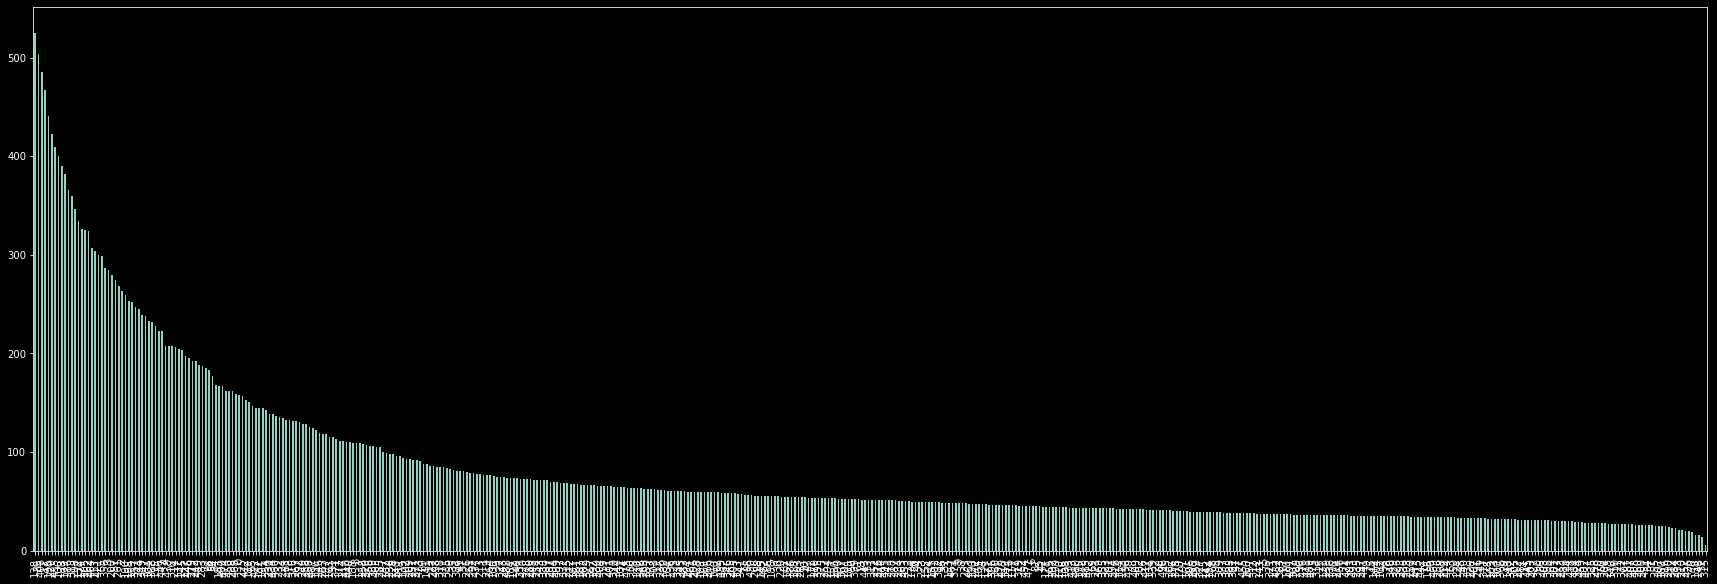

In [8]:
dataset["label"].value_counts().plot.bar(figsize=(30,10));

In [9]:
np.median(dataset["label"].value_counts().values)

51.0

In [10]:
# excl_labels = []
# for label in dataset["label"].unique():
#     if dataset["label"].value_counts()[label] < len(dataset) * 0.001:
#         excl_labels.append(label)

# for label in excl_labels:
#     dataset = dataset[dataset["label"] != label]


In [11]:
# dataset["label"].value_counts().plot.bar(figsize=(30,10));

In [12]:
N_CLASS = len(dataset["label"].value_counts())
N_CLASS

500

In [55]:
train_dataset, test_dataset = train_test_split(dataset, shuffle=True, test_size=0.1, random_state=SEED, stratify=dataset["label"])
train_dataset, valid_dataset = train_test_split(train_dataset, shuffle=True, test_size=0.15, random_state=SEED, stratify=train_dataset["label"])
train_dataset_labels = train_dataset["label"].values
test_dataset_labels = test_dataset["label"].values

In [56]:
assert len(train_dataset["label"].value_counts()) == len(test_dataset["label"].value_counts())
assert len(train_dataset["label"].value_counts()) == len(valid_dataset["label"].value_counts())

In [57]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transforms=None):
        super().__init__()
        self.image_paths = dataset['image_path'].values
        self.labels = dataset['label'].values
        self.image_qualities = dataset['image_quality'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):    
        image, label = self.image_paths[index], self.labels[index]        
        
        image = cv2.imread(image)
        # fast BGR to RGB
        image = image[: , : , ::-1]
        if image.shape[-1] == 4:
            # removing alpha channel if present
            image = image[..., :3]
        if len(image.shape) == 2:
            # converting single channel image to 3 channel for possible greyscales
            image = np.stack((image,)  * 3, axis = -1)

        if self.transforms is not None:
            transformed = self.transforms(image=image)

            image = transformed["image"]

        return image, label

transform = Compose([
            Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),
            HorizontalFlip(p=0.4),
            ShiftScaleRotate(p=0.3),
            MedianBlur(blur_limit=7, always_apply=False, p=0.3),
            IAAAdditiveGaussianNoise(scale=(0, 0.15*255), p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.4),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.4),
            ToTensorV2(p=1.0),
            ], p=1.0)

test_transform = Compose([
            # only resize and normalization is used for testing
            # no TTA is implemented in this solution
            Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),                    
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
            ], p=1.0)


train_dataset, valid_dataset = Dataset(train_dataset, transforms = transform), Dataset(valid_dataset, transforms = transform)
test_dataset = Dataset(test_dataset, transforms = test_transform)

In [58]:
# https://github.com/ufoym/imbalanced-dataset-sampler
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, num_samples: int = None):
        self.indices = list(range(len(dataset)))
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            label_to_count[label] = label_to_count.get(label, 0) + 1
        
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)] for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.labels[idx]

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [59]:
train_dataloader = DataLoader(train_dataset,
                            #balanced sampler is used to minimize harmful effects of dataset not being fully balanced 
                            #sampler=BalanceClassSampler(labels=train_dataset_labels, mode="upsampling"),           
                            sampler=ImbalancedDatasetSampler(train_dataset, num_samples=10000),
                            batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(
                            valid_dataset,
                            sampler=ImbalancedDatasetSampler(valid_dataset, num_samples=2000),
                            batch_size=BATCH_SIZE)
test_dataloader = DataLoader(
                            test_dataset,
                            sampler=SequentialSampler(test_dataset),
                            batch_size=1)
test_dataloader_balanced = DataLoader(
                            test_dataset,
                            #sampler=ImbalancedDatasetSampler(test_dataset, num_samples=2000),
                            sampler=BalanceClassSampler(labels=test_dataset_labels, mode="downsampling"),
                            batch_size=1)

In [60]:
class Classifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        self.model.drop_rate = 0.25
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        
    def forward(self, x):
        x = self.model(x)
        x = F.softmax(x, dim=1)
        return x

net = Classifier("tf_efficientnet_b4_ns", N_CLASS).to(device)

In [64]:
loss_function  = nn.CrossEntropyLoss()
#optimizer = torch.optim.AdamW(net.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.95), weight_decay=0.999)
optimizer = Ranger(net.parameters(),
                alpha=0.5, k=6, N_sma_threshhold=5,
                betas=(0.95, 0.999),
                lr=LEARNING_RATE,
                weight_decay=0.95)

scheduler = CosineAnnealingLR(optimizer, EPOCHS * 0.25, LEARNING_RATE * 0.0001)
scheduler.last_epoch = EPOCHS
scaler = GradScaler()

def training_loop():
    best_model_wts = copy.deepcopy(net.state_dict())
    best_loss = float("inf")
    
    for epoch in (range(EPOCHS)):        
        if epoch != 0 and epoch > 0.25 * EPOCHS: # cosine anneal the last 25% of epochs
            scheduler.step()
        logging.info(f"Epoch {epoch+1}")

        logging.info("Training")
        train_losses, train_accuracies, train_f1 = forward_pass(train_dataloader, train = True)

        logging.info("Validating")
        val_losses, val_accuracies, val_f1 = forward_pass(valid_dataloader)

        logging.info(f"Training accuracy: {sum(train_accuracies)/len(train_accuracies):.2f} | Training loss: {sum(train_losses)/len(train_losses):.2f}")
        logging.info(f"Training f1:   {sum(train_f1)/len(train_f1):.2f}")
        logging.info(f"Validation accuracy: {sum(val_accuracies)/len(val_accuracies):.2f} | Validation loss: {sum(val_losses)/len(val_losses):.2f}")
        logging.info(f"Validation f1:   {sum(val_f1)/len(val_f1):.2f}")
        
        epoch_val_loss = sum(val_losses)/len(val_losses)
        
        if best_loss > epoch_val_loss:
            best_model_wts = copy.deepcopy(net.state_dict())
            torch.save(net.state_dict(), "best.pth")
            logging.info(f"Saving with loss of {epoch_val_loss}, improved over previous {best_loss}")
            best_loss = epoch_val_loss

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [65]:
def forward_pass(dataloader, train=False):
    if train:
        net.train()
    else:
        net.eval()

    losses = deque(maxlen=5000)
    accuracies = deque(maxlen=5000)
    f1_scores = deque(maxlen=5000)

    for step, batch in (enumerate(dataloader)):
        inputs = batch[0].to(device).float()
        labels = batch[1].to(device).long()          

        with autocast():
            if train:
                outputs = net(inputs)
                loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
            else:
                with torch.no_grad():
                    outputs = net(inputs)
                    loss = loss_function(outputs, labels)
        
        predicted_labels = [torch.argmax(i).item() for i in outputs]
        labels = labels.cpu().numpy()
        acc = metrics.accuracy_score(labels, predicted_labels)
        f1_score = metrics.f1_score(labels, predicted_labels, average='macro')
        
        losses.append(loss)
        accuracies.append(acc)
        f1_scores.append(f1_score)
        
        if train and (step+1) % GRADIENT_ACCUMULATION_STEPS == 0:
        # gradient accumulation to train with bigger effective batch size
        # with less memory use
        # fp16 is used to speed up training and reduce memory consumption
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()            
            logging.info(f"Step {step} of {len(train_dataloader)},\t"\
                        f"Accuracy: {sum(accuracies)/len(accuracies):.2f},\t"\
                        f"Loss: {sum(losses)/len(losses):.2f},\t"\
                        f"F1: {sum(f1_scores)/len(f1_scores):.2f}")

    return losses, accuracies, f1_scores


In [63]:
training_loop()

INFO:root:Epoch 1
INFO:root:Training
INFO:root:Step 9 of 834,	Accuracy: 0.00,	Loss: 6.21,	F1: 0.00
INFO:root:Step 19 of 834,	Accuracy: 0.00,	Loss: 6.21,	F1: 0.00
INFO:root:Step 29 of 834,	Accuracy: 0.00,	Loss: 6.21,	F1: 0.00
INFO:root:Step 39 of 834,	Accuracy: 0.00,	Loss: 6.21,	F1: 0.00


KeyboardInterrupt: 

In [ ]:
def test(dataloader):
    net.eval()

    predicted_labels_l = []
    labels_l = []
    loss_l = []

    for step, batch in tqdm_notebook((enumerate(dataloader))):
        inputs = batch[0].to(device).float()
        labels = batch[1].to(device).long()          

        with autocast():            
            with torch.no_grad():
                outputs = net(inputs)
                loss = loss_function(outputs, labels)
        
        predicted_labels = [torch.argmax(i).item() for i in outputs]
        labels = labels.cpu().numpy()
        
        predicted_labels_l.append(predicted_labels)
        labels_l.append(labels)
        loss_l.append(loss)

    avg_loss = sum(loss_l)/len(loss_l)
    clf_report = metrics.classification_report(labels_l, predicted_labels_l) 

    return avg_loss, clf_report

In [ ]:
start = time.time()
test_losses, test_clf_report = test(dataloader=test_dataloader)
total_time = time.time() - start

logging.info("\n" + test_clf_report)
logging.info(f"Average inference time is: {total_time/len(test_dataloader):.3f}")
logging.info(f"Test loss: {test_losses:.2f}")

In [ ]:
start = time.time()
test_losses, test_clf_report = test(dataloader=test_dataloader_balanced)
total_time = time.time() - start

logging.info("\n" + test_clf_report)
logging.info(f"Average inference time is: {total_time/len(test_dataloader_balanced):.3f}")
logging.info(f"Test accuracy: {test_accuracies:.2f} | Test loss: {test_losses:.2f} | Test F1: {test_f1:.2f}")